In [1]:
pwd

'/content'

In [1]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [3]:
mkdir FDP_Demo

In [2]:
cd FDP_Demo

/content/drive/MyDrive/FDP_Demo


#Install the classic Jupyter Notebook with:


```
pip install notebook
```

# To run the notebook:



```
jupyter notebook
```



#Demo 1: Backpropagation Algorithm Training


*   A tiny neural network learns a simple function (e.g., XOR or a 2D classification).
*   Show forward pass -> loss -> gradients -> parameter update.

Print and visualize:

*   loss decreasing
*   gradient norms, Decision Boundary




## i) Imports + Toy Data

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

torch.manual_seed(0)

# XOR dataset (4 points)
X = torch.tensor([[0.,0.],
                  [0.,1.],
                  [1.,0.],
                  [1.,1.]])
y = torch.tensor([[0.],
                  [1.],
                  [1.],
                  [0.]])


## ii) Tiny MLP

In [4]:
model = nn.Sequential(
    nn.Linear(2, 8),
    nn.Tanh(),
    nn.Linear(8, 1)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.5)
loss_fn = nn.BCEWithLogitsLoss()


## iii) One step backpropagation and see what backpropagation produces

In [5]:
# Forward
logits = model(X)
loss = loss_fn(logits, y)

# Backward
optimizer.zero_grad()
loss.backward()

print("Loss:", float(loss))

# Inspect gradients (what backprop produced)
for name, p in model.named_parameters():
    print(f"{name:15s} | grad_norm = {p.grad.norm().item():.6f}")

# One optimizer step (gradient descent)
optimizer.step()


Loss: 0.7011651396751404
0.weight        | grad_norm = 0.036218
0.bias          | grad_norm = 0.039385
2.weight        | grad_norm = 0.102081
2.bias          | grad_norm = 0.076644


/tmp/ipython-input-2243824308.py:9: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  print("Loss:", float(loss))


## Training Loop (Loss Curve)

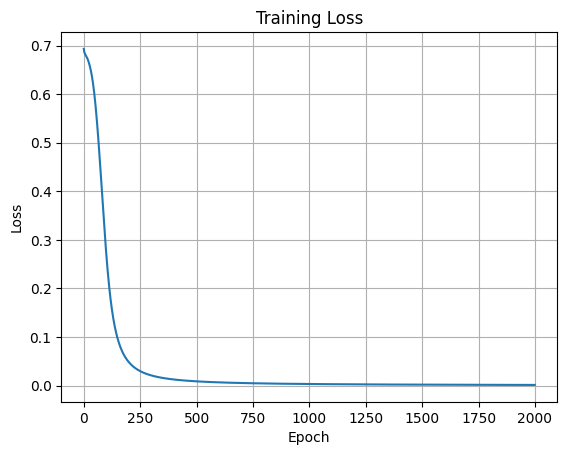

In [6]:
losses = []
for epoch in range(2000):
    logits = model(X)
    loss = loss_fn(logits, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(float(loss))

plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


## Inference after training

In [7]:
with torch.no_grad():
    probs = torch.sigmoid(model(X))
    preds = (probs > 0.5).float()

print("Input:\n", X)
print("Probabilities:\n", probs)
print("Predictions:\n", preds)
print("GT:\n", y)


Input:
 tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]])
Probabilities:
 tensor([[0.0011],
        [0.9986],
        [0.9987],
        [0.0014]])
Predictions:
 tensor([[0.],
        [1.],
        [1.],
        [0.]])
GT:
 tensor([[0.],
        [1.],
        [1.],
        [0.]])


## Visual decision bopundary (2D)

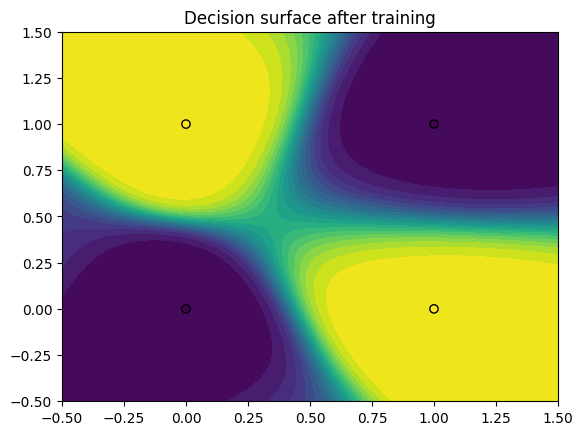

In [8]:
import numpy as np

xx, yy = np.meshgrid(np.linspace(-0.5, 1.5, 200), np.linspace(-0.5, 1.5, 200))
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

with torch.no_grad():
    zz = torch.sigmoid(model(grid)).reshape(xx.shape).numpy()

plt.contourf(xx, yy, zz, levels=20)
plt.scatter(X[:,0], X[:,1], c=y[:,0], edgecolor='k')
plt.title("Decision surface after training")
plt.show()


# Demo 2: CNN + GradCAM (with pretrained model)

## imports

In [9]:
import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


## load pretrained CNN (ResNet18)

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

weights = torchvision.models.ResNet18_Weights.DEFAULT
model = torchvision.models.resnet18(weights=weights).to(device)
model.eval()

preprocess = weights.transforms()
categories = weights.meta["categories"]

print("Device:", device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 202MB/s]


Device: cuda


## load an image

Saving crane.jpg to crane.jpg


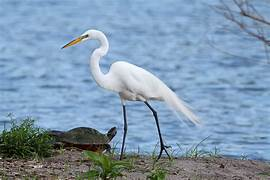

In [22]:
from google.colab import files
uploaded = files.upload()
img_path = next(iter(uploaded.keys()))
img = Image.open(img_path).convert("RGB")
img


## preprocess + inference

In [23]:
x = preprocess(img).unsqueeze(0).to(device)

with torch.no_grad():
    logits = model(x)
    probs = F.softmax(logits, dim=1)
    pred_id = probs.argmax(dim=1).item()
    pred_name = categories[pred_id]
    pred_prob = probs[0, pred_id].item()

print("Prediction:", pred_name, "| prob:", round(pred_prob, 4))


Prediction: American egret | prob: 0.9775


## grad-CAM implementation

In [25]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, inp, out):
            self.activations = out

        def backward_hook(module, grad_in, grad_out):
            # grad_out is a tuple; we need gradient w.r.t. layer output
            self.gradients = grad_out[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def __call__(self, x, class_idx=None):
        self.model.zero_grad()

        logits = self.model(x)
        if class_idx is None:
            class_idx = logits.argmax(dim=1).item()

        score = logits[0, class_idx]
        score.backward()

        # Global-average-pool gradients over spatial dims -> weights
        grads = self.gradients[0]              # [C, H, W]
        acts = self.activations[0]             # [C, H, W]
        weights = grads.mean(dim=(1, 2))       # [C]

        cam = (weights[:, None, None] * acts).sum(dim=0)  # [H, W]
        cam = F.relu(cam)

        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        return cam.detach().cpu().numpy(), class_idx


## Run Grad-CAM on ResNet18’s last conv block

In [26]:
# ResNet18: last conv feature map is model.layer4
cam_engine = GradCAM(model, model.layer4)

x.requires_grad_(True)
cam, class_idx = cam_engine(x, class_idx=pred_id)

print("Grad-CAM class:", categories[class_idx])


Grad-CAM class: American egret


## Overlay heatmap on the original image

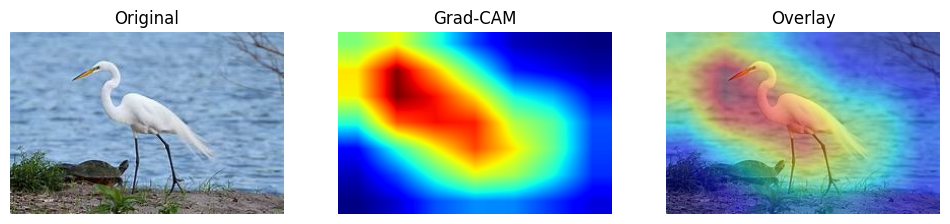

In [27]:
def show_cam_on_image(pil_img, cam, alpha=0.45):
    img_np = np.array(pil_img).astype(np.float32) / 255.0

    # Resize CAM to image size
    cam_t = torch.tensor(cam)[None, None, ...]
    cam_resized = F.interpolate(cam_t, size=img_np.shape[:2], mode="bilinear", align_corners=False)[0,0].numpy()

    # Simple colormap using matplotlib
    heatmap = plt.cm.jet(cam_resized)[..., :3]  # RGB

    overlay = (1 - alpha) * img_np + alpha * heatmap
    overlay = np.clip(overlay, 0, 1)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.title("Original"); plt.imshow(img_np); plt.axis("off")
    plt.subplot(1,3,2); plt.title("Grad-CAM"); plt.imshow(cam_resized, cmap="jet"); plt.axis("off")
    plt.subplot(1,3,3); plt.title("Overlay"); plt.imshow(overlay); plt.axis("off")
    plt.show()

show_cam_on_image(img, cam)


# Demo 2: Scratch CNN + GradCAM (Training a scratch CNN model)

## imports + device setup

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(0)
print("Device:", device)


Device: cuda


## dataset and train/val/test loaders

In [35]:
transform = transforms.Compose([transforms.ToTensor()])

train_full = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_ds    = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)
classes = train_full.classes

# Split train_full -> train/val
train_size = int(0.9 * len(train_full))
val_size   = len(train_full) - train_size
train_ds, val_ds = random_split(train_full, [train_size, val_size],
                                generator=torch.Generator().manual_seed(0))

# subset for demo (we can comment this line to use full train set)
train_ds = Subset(train_ds, range(20000))  # 20k samples for quick 10 epochs

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=256, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

print("Train batches:", len(train_loader), "| Val batches:", len(val_loader), "| Test batches:", len(test_loader))
print("Classes:", classes)


Train batches: 157 | Val batches: 24 | Test batches: 40
Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


## scratch CNN model

In [36]:
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),  # 28x28
            nn.ReLU(),
            nn.MaxPool2d(2),                 # 14x14

            nn.Conv2d(16, 32, 3, padding=1), # 14x14
            nn.ReLU(),
            nn.MaxPool2d(2),                 # 7x7

            nn.Conv2d(32, 64, 3, padding=1), # 7x7  <-- good Grad-CAM target
            nn.ReLU(),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SmallCNN().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

model


SmallCNN(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

## train and eval functions (loss, accuracy )

In [37]:
def train_one_epoch(model, loader, optimizer):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        logits = model(x)
        loss = loss_fn(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    return total_loss / total, correct / total


@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        logits = model(x)
        loss = loss_fn(logits, y)

        total_loss += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    return total_loss / total, correct / total


## train for few epochs (train and val metrics)

In [38]:
epochs = 10
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for ep in range(1, epochs + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, opt)
    va_loss, va_acc = evaluate(model, val_loader)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(va_acc)

    print(
        f"Epoch {ep:02d}/{epochs} | "
        f"Train: loss={tr_loss:.4f}, acc={tr_acc*100:.2f}% | "
        f"Val: loss={va_loss:.4f}, acc={va_acc*100:.2f}%"
    )


Epoch 01/10 | Train: loss=0.8575, acc=68.31% | Val: loss=0.5169, acc=80.13%
Epoch 02/10 | Train: loss=0.4936, acc=81.77% | Val: loss=0.4139, acc=84.70%
Epoch 03/10 | Train: loss=0.4109, acc=85.04% | Val: loss=0.3690, acc=86.85%
Epoch 04/10 | Train: loss=0.3603, acc=87.02% | Val: loss=0.3457, acc=87.80%
Epoch 05/10 | Train: loss=0.3300, acc=87.86% | Val: loss=0.3203, acc=88.47%
Epoch 06/10 | Train: loss=0.3064, acc=88.55% | Val: loss=0.3265, acc=88.08%
Epoch 07/10 | Train: loss=0.2852, acc=89.48% | Val: loss=0.2888, acc=89.58%
Epoch 08/10 | Train: loss=0.2614, acc=90.53% | Val: loss=0.2902, acc=89.48%
Epoch 09/10 | Train: loss=0.2468, acc=90.77% | Val: loss=0.2844, acc=89.72%
Epoch 10/10 | Train: loss=0.2276, acc=91.69% | Val: loss=0.2812, acc=89.68%


## final testing ( test loss , test accuracy)

In [39]:
te_loss, te_acc = evaluate(model, test_loader)
print(f"TEST | loss={te_loss:.4f} | acc={te_acc*100:.2f}%")


TEST | loss=0.3043 | acc=88.76%


## plots for loss and accuracy

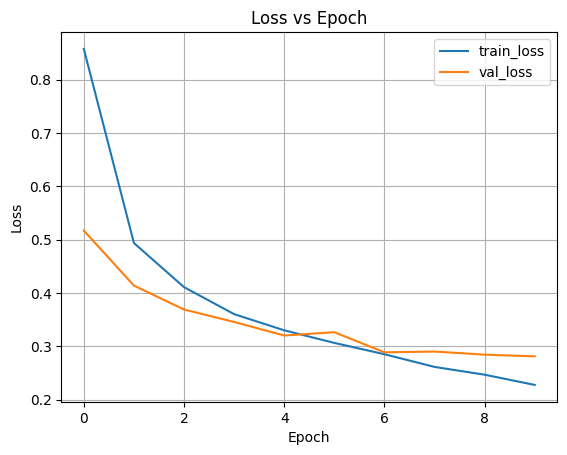

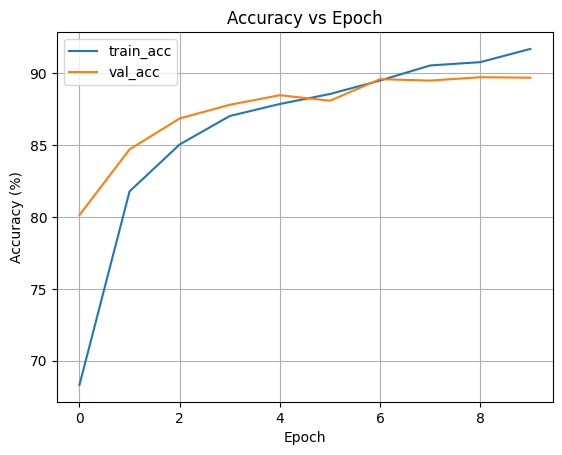

In [40]:
plt.figure()
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot([a*100 for a in history["train_acc"]], label="train_acc")
plt.plot([a*100 for a in history["val_acc"]], label="val_acc")
plt.title("Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()


## inference on one test image (we can choose by id)

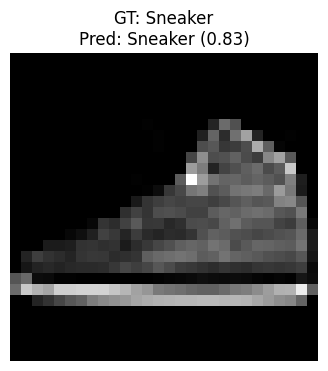

In [59]:
idx = 45  # we can change this for diff images.
img, label = test_ds[idx]

model.eval()
with torch.no_grad():
    logits = model(img.unsqueeze(0).to(device))
    probs = F.softmax(logits, dim=1)[0]
    pred = probs.argmax().item()
    conf = probs[pred].item()

plt.figure(figsize=(4,4))
plt.imshow(img.squeeze(0), cmap="gray")
plt.title(f"GT: {classes[label]}\nPred: {classes[pred]} ({conf:.2f})")
plt.axis("off")
plt.show()


## gradCAM implementation

In [60]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, inp, out):
            self.activations = out

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]  # gradient w.r.t. layer output

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def __call__(self, x, class_idx=None):
        self.model.zero_grad()

        logits = self.model(x)
        if class_idx is None:
            class_idx = logits.argmax(dim=1).item()

        score = logits[0, class_idx]
        score.backward()

        grads = self.gradients[0]        # [C,H,W]
        acts  = self.activations[0]      # [C,H,W]
        weights = grads.mean(dim=(1,2))  # [C]

        cam = (weights[:, None, None] * acts).sum(dim=0)  # [H,W]
        cam = F.relu(cam)

        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        return cam.detach().cpu().numpy(), class_idx


## gradCAM heatmap + overlay

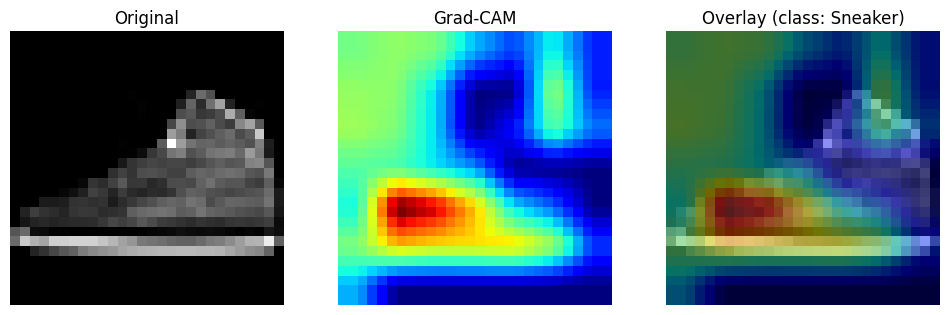

In [61]:
# Target last conv layer (Conv2d 32->64)
target_layer = model.features[6]
cam_engine = GradCAM(model, target_layer)

x = img.unsqueeze(0).to(device)
x.requires_grad_(True)

cam, cam_class = cam_engine(x, class_idx=None)  # None = predicted class

# Upsample CAM to 28x28
cam_t = torch.tensor(cam)[None, None, ...]
cam_up = F.interpolate(cam_t, size=(28, 28), mode="bilinear", align_corners=False)[0,0].numpy()

img_np = img.squeeze(0).numpy()

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(img_np, cmap="gray")
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Grad-CAM")
plt.imshow(cam_up, cmap="jet")
plt.axis("off")

plt.subplot(1,3,3)
plt.title(f"Overlay (class: {classes[cam_class]})")
plt.imshow(img_np, cmap="gray")
plt.imshow(cam_up, cmap="jet", alpha=0.45)
plt.axis("off")

plt.show()


# Demo 3: Vanilla GAN

## imports and device setup

In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(0)
print("Device:", device)


Device: cuda


## dataset ->  mnist , dataloader

In [63]:
transform = transforms.Compose([
    transforms.ToTensor(),               # [0,1]
    transforms.Normalize((0.5,), (0.5,)) # -> [-1,1] (better for GAN with Tanh)
])

mnist = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# split: train/val
train_size = int(0.95 * len(mnist))
val_size = len(mnist) - train_size
train_ds, val_ds = random_split(mnist, [train_size, val_size],
                                generator=torch.Generator().manual_seed(0))

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

print("Train batches:", len(train_loader), "| Val batches:", len(val_loader))


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 506kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 17.1MB/s]

Train batches: 446 | Val batches: 12


## vanilla GAN : Generator and Discriminator (MLPs)

In [64]:
img_dim = 28 * 28
z_dim = 100

class Generator(nn.Module):
    def __init__(self, z_dim=100, img_dim=784):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, img_dim),
            nn.Tanh()  # output in [-1,1]
        )

    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self, img_dim=784):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(img_dim, 512),
            nn.LeakyReLU(0.2, True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, True),
            nn.Linear(256, 1)  # logits
        )

    def forward(self, x):
        return self.net(x)

G = Generator(z_dim, img_dim).to(device)
D = Discriminator(img_dim).to(device)

# Loss: BCE with logits (stable)
criterion = nn.BCEWithLogitsLoss()

opt_G = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

print(G)
print(D)


Generator(
  (net): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Tanh()
  )
)
Discriminator(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)


## visualize generated samples

In [65]:
@torch.no_grad()
def show_generated(G, z_dim=100, n=16, title="Generated"):
    G.eval()
    z = torch.randn(n, z_dim, device=device)
    fake = G(z).view(n, 28, 28).cpu()

    # fake is in [-1,1], convert to [0,1] for plotting
    fake = (fake + 1) / 2

    plt.figure(figsize=(4,4))
    for i in range(n):
        plt.subplot(4,4,i+1)
        plt.imshow(fake[i], cmap="gray")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()


## training loop and loss curves

Epoch 01/10 | D_loss=0.4402 | G_loss=1.5807


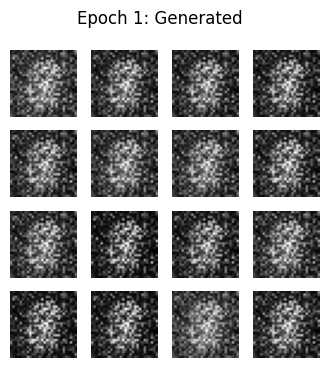

Epoch 02/10 | D_loss=0.2017 | G_loss=3.3131


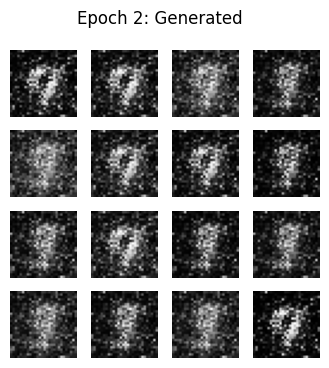

Epoch 03/10 | D_loss=0.2393 | G_loss=3.0214


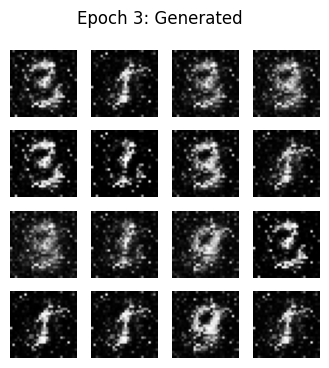

Epoch 04/10 | D_loss=0.1914 | G_loss=3.8705


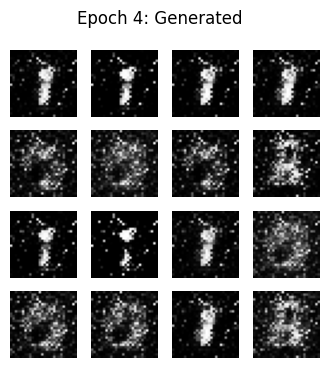

Epoch 05/10 | D_loss=0.2168 | G_loss=3.2245


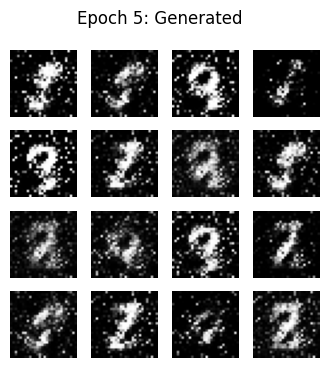

Epoch 06/10 | D_loss=0.2031 | G_loss=3.9694


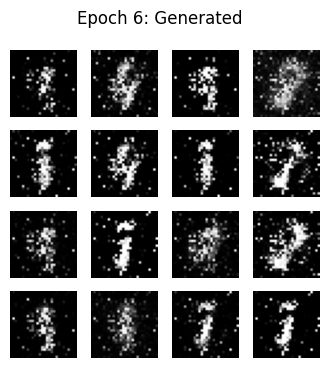

Epoch 07/10 | D_loss=0.2288 | G_loss=3.3469


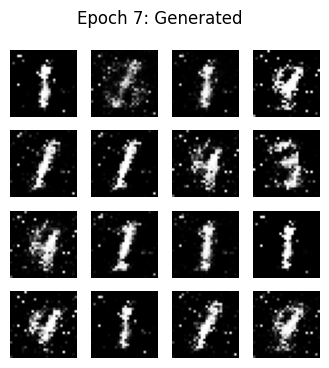

Epoch 08/10 | D_loss=0.2273 | G_loss=3.1453


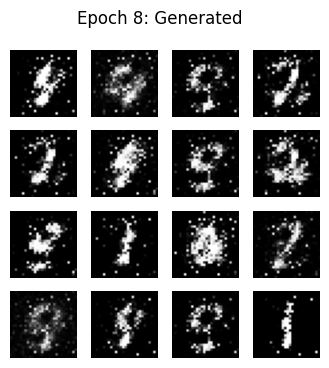

Epoch 09/10 | D_loss=0.2320 | G_loss=3.1566


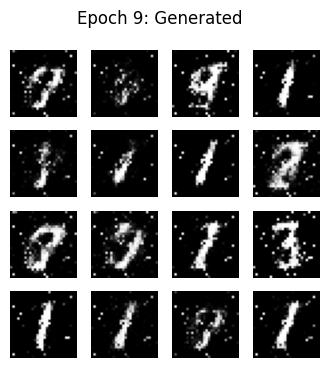

Epoch 10/10 | D_loss=0.2536 | G_loss=3.0102


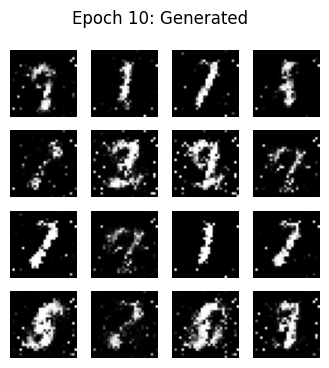

In [66]:
def train_gan(G, D, train_loader, epochs=10):
    G.train(); D.train()
    G_losses, D_losses = [], []

    for ep in range(1, epochs+1):
        running_g, running_d = 0.0, 0.0
        num_batches = 0

        for real_imgs, _ in train_loader:
            real_imgs = real_imgs.to(device)             # [B,1,28,28]
            B = real_imgs.size(0)
            real_flat = real_imgs.view(B, -1)            # [B,784]

            # Labels
            real_y = torch.ones(B, 1, device=device)
            fake_y = torch.zeros(B, 1, device=device)

            # -------------------------
            # 1) Train Discriminator
            # -------------------------
            z = torch.randn(B, z_dim, device=device)
            fake_flat = G(z).detach()  # detach so D update doesn't affect G

            D_real = D(real_flat)
            D_fake = D(fake_flat)

            loss_D_real = criterion(D_real, real_y)
            loss_D_fake = criterion(D_fake, fake_y)
            loss_D = (loss_D_real + loss_D_fake) / 2

            opt_D.zero_grad()
            loss_D.backward()
            opt_D.step()

            # -------------------------
            # 2) Train Generator
            # -------------------------
            z = torch.randn(B, z_dim, device=device)
            fake_flat = G(z)
            D_fake_for_G = D(fake_flat)

            # Generator wants D(fake) -> 1
            loss_G = criterion(D_fake_for_G, real_y)

            opt_G.zero_grad()
            loss_G.backward()
            opt_G.step()

            running_d += loss_D.item()
            running_g += loss_G.item()
            num_batches += 1

        avg_d = running_d / num_batches
        avg_g = running_g / num_batches
        D_losses.append(avg_d)
        G_losses.append(avg_g)

        print(f"Epoch {ep:02d}/{epochs} | D_loss={avg_d:.4f} | G_loss={avg_g:.4f}")
        show_generated(G, z_dim=z_dim, n=16, title=f"Epoch {ep}: Generated")

    return D_losses, G_losses

epochs = 10
D_losses, G_losses = train_gan(G, D, train_loader, epochs=epochs)


## plot losses

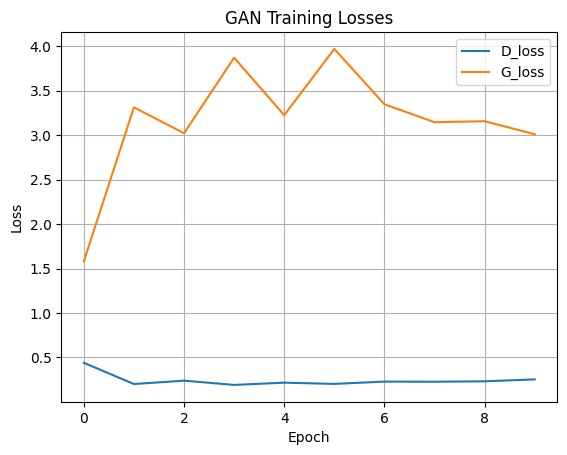

In [67]:
plt.figure()
plt.plot(D_losses, label="D_loss")
plt.plot(G_losses, label="G_loss")
plt.title("GAN Training Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


## testing time: i) generate digits

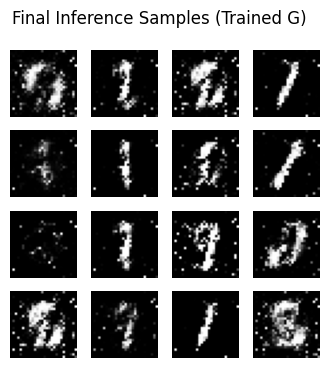

In [68]:
show_generated(G, z_dim=z_dim, n=16, title="Final Inference Samples (Trained G)")



## check D's confidence : real or fake

In [69]:
@torch.no_grad()
def discriminator_confidence(D, G, loader, n_batches=10):
    D.eval(); G.eval()
    real_scores, fake_scores = [], []

    it = iter(loader)
    for _ in range(n_batches):
        real_imgs, _ = next(it)
        real_imgs = real_imgs.to(device)
        B = real_imgs.size(0)

        real_flat = real_imgs.view(B, -1)
        z = torch.randn(B, z_dim, device=device)
        fake_flat = G(z)

        real_logit = D(real_flat)
        fake_logit = D(fake_flat)

        real_prob = torch.sigmoid(real_logit).mean().item()
        fake_prob = torch.sigmoid(fake_logit).mean().item()

        real_scores.append(real_prob)
        fake_scores.append(fake_prob)

    return float(np.mean(real_scores)), float(np.mean(fake_scores))

real_p, fake_p = discriminator_confidence(D, G, DataLoader(test_ds, batch_size=256, shuffle=True))
print(f"Test sanity check | D(real) avg prob={real_p:.3f} | D(fake) avg prob={fake_p:.3f}")


Test sanity check | D(real) avg prob=0.906 | D(fake) avg prob=0.302


# Demo 3: DCGAN

In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(0)
print("Device:", device)


Device: cuda


In [71]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # -> [-1, 1] for Tanh
])

train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

print("Train batches:", len(train_loader))


Train batches: 469


In [72]:
z_dim = 100

class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super().__init__()
        # z -> 128x7x7 -> 64x14x14 -> 1x28x28
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 128, 7, 1, 0, bias=False),  # (B,128,7,7)
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),     # (B,64,14,14)
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),       # (B,1,28,28)
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # 1x28x28 -> 64x14x14 -> 128x7x7 -> 1
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),                # (B,64,14,14)
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),              # (B,128,7,7)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, True),

            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1)                             # logits
        )

    def forward(self, x):
        return self.net(x)

G = Generator(z_dim).to(device)
D = Discriminator().to(device)

criterion = nn.BCEWithLogitsLoss()
opt_G = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

print(G)
print(D)


Generator(
  (net): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): Tanh()
  )
)
Discriminator(
  (net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Flatten(start_dim=1, e

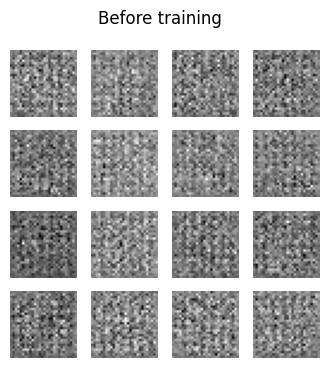

In [73]:
@torch.no_grad()
def show_generated(G, fixed_z, title="Generated"):
    G.eval()
    fake = G(fixed_z).cpu()               # (N,1,28,28) in [-1,1]
    fake = (fake + 1) / 2                 # -> [0,1]

    n = fake.size(0)
    grid = int(np.sqrt(n))

    plt.figure(figsize=(4,4))
    for i in range(n):
        plt.subplot(grid, grid, i+1)
        plt.imshow(fake[i,0], cmap="gray")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

fixed_z = torch.randn(16, z_dim, 1, 1, device=device)
show_generated(G, fixed_z, title="Before training")


Epoch 01/10 | D_loss=0.3295 | G_loss=1.8725


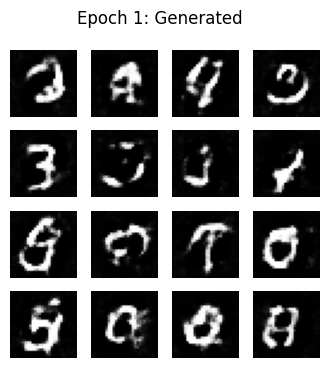

Epoch 02/10 | D_loss=0.3062 | G_loss=1.6910


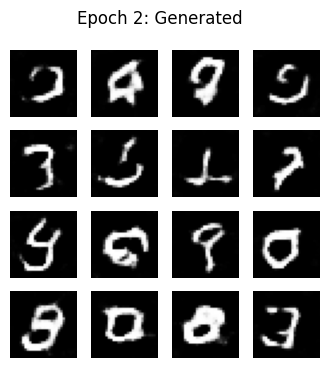

Epoch 03/10 | D_loss=0.2706 | G_loss=1.8850


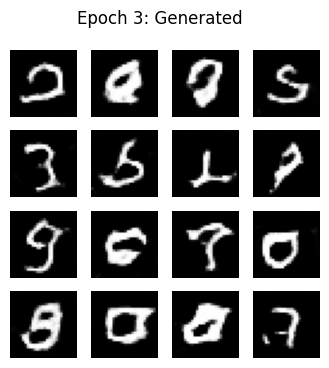

Epoch 04/10 | D_loss=0.2642 | G_loss=1.9500


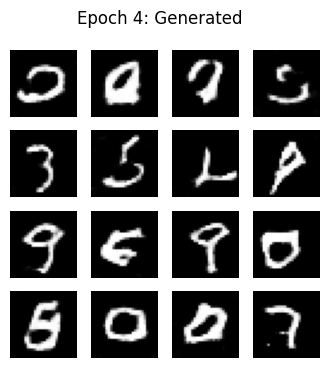

Epoch 05/10 | D_loss=0.2610 | G_loss=2.0326


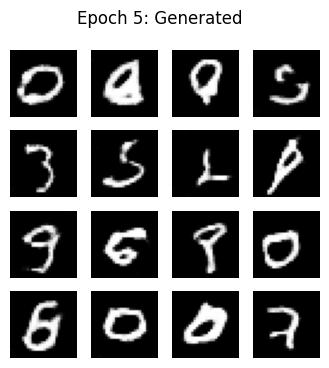

Epoch 06/10 | D_loss=0.2533 | G_loss=2.0819


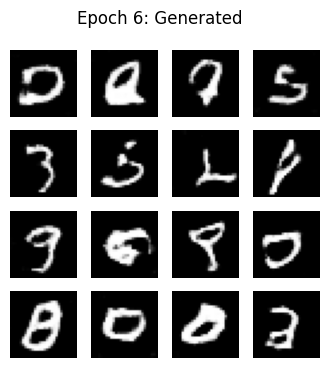

Epoch 07/10 | D_loss=0.2577 | G_loss=2.0970


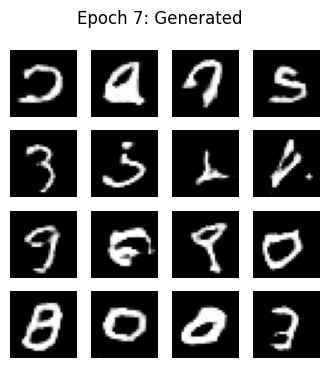

Epoch 08/10 | D_loss=0.2784 | G_loss=2.0700


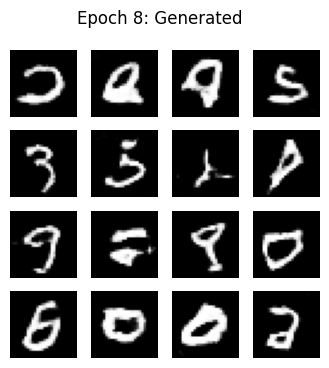

Epoch 09/10 | D_loss=0.2635 | G_loss=2.1116


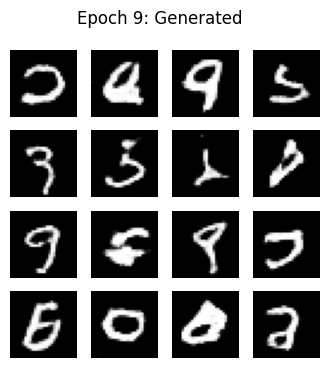

Epoch 10/10 | D_loss=0.2551 | G_loss=2.1653


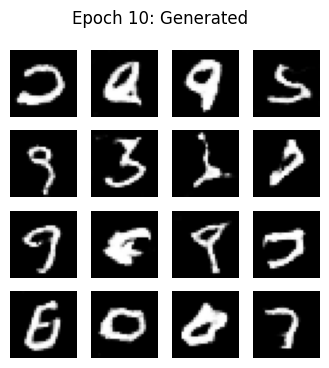

In [74]:
def train_dcgan(G, D, train_loader, epochs=10):
    G.train(); D.train()
    G_losses, D_losses = [], []

    for ep in range(1, epochs+1):
        running_g, running_d, nb = 0.0, 0.0, 0

        for real_imgs, _ in train_loader:
            real_imgs = real_imgs.to(device)
            B = real_imgs.size(0)

            real_y = torch.ones(B, 1, device=device)
            fake_y = torch.zeros(B, 1, device=device)

            # Train Discriminator
            z = torch.randn(B, z_dim, 1, 1, device=device)
            fake_imgs = G(z).detach()

            D_real = D(real_imgs)
            D_fake = D(fake_imgs)

            loss_D_real = criterion(D_real, real_y)
            loss_D_fake = criterion(D_fake, fake_y)
            loss_D = (loss_D_real + loss_D_fake) / 2

            opt_D.zero_grad()
            loss_D.backward()
            opt_D.step()

            # Train Generator
            z = torch.randn(B, z_dim, 1, 1, device=device)
            fake_imgs = G(z)
            D_fake_for_G = D(fake_imgs)

            loss_G = criterion(D_fake_for_G, real_y)

            opt_G.zero_grad()
            loss_G.backward()
            opt_G.step()

            running_d += loss_D.item()
            running_g += loss_G.item()
            nb += 1

        avg_d = running_d / nb
        avg_g = running_g / nb
        D_losses.append(avg_d)
        G_losses.append(avg_g)

        print(f"Epoch {ep:02d}/{epochs} | D_loss={avg_d:.4f} | G_loss={avg_g:.4f}")
        show_generated(G, fixed_z, title=f"Epoch {ep}: Generated")

    return D_losses, G_losses

epochs = 10
D_losses, G_losses = train_dcgan(G, D, train_loader, epochs=epochs)


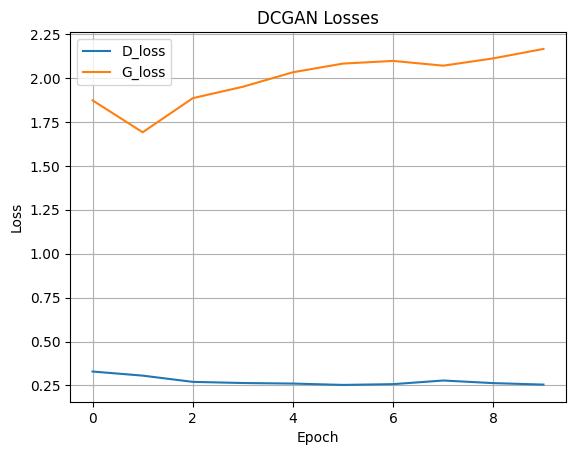

In [75]:
plt.figure()
plt.plot(D_losses, label="D_loss")
plt.plot(G_losses, label="G_loss")
plt.title("DCGAN Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


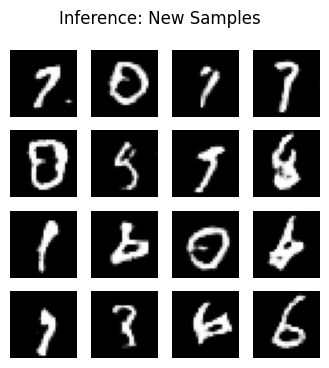

In [76]:
z = torch.randn(16, z_dim, 1, 1, device=device)
show_generated(G, z, title="Inference: New Samples")


In [77]:
@torch.no_grad()
def disc_confidence(D, G, loader, n_batches=10):
    D.eval(); G.eval()
    real_ps, fake_ps = [], []
    it = iter(loader)

    for _ in range(n_batches):
        real_imgs, _ = next(it)
        real_imgs = real_imgs.to(device)
        B = real_imgs.size(0)

        z = torch.randn(B, z_dim, 1, 1, device=device)
        fake_imgs = G(z)

        real_p = torch.sigmoid(D(real_imgs)).mean().item()
        fake_p = torch.sigmoid(D(fake_imgs)).mean().item()
        real_ps.append(real_p); fake_ps.append(fake_p)

    return float(np.mean(real_ps)), float(np.mean(fake_ps))

real_p, fake_p = disc_confidence(D, G, test_loader, n_batches=10)
print(f"TEST sanity | D(real) avg prob={real_p:.3f} | D(fake) avg prob={fake_p:.3f}")


TEST sanity | D(real) avg prob=0.348 | D(fake) avg prob=0.068
